Note:
    This notebook was inspired by a lab in the Advanced Deep Learning course. 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
import pickle
import urllib.request
import os 

import numpy as np
from PIL import Image

%matplotlib inline

### Download the Model
Pretrained model `ResNet-34` for `ImageNet` classification dataset.
* **ImageNet**: A large dataset of photographs with 1 000 classes.
* **ResNet-34**: A deep architecture for image classification.

In [3]:
resnet34 = models.resnet34(pretrained=True)
resnet34.eval() # set the model to evaluation mode

/Users/adrienloizeau/opt/anaconda3/envs/cs/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/adrienloizeau/opt/anaconda3/envs/cs/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

![ResNet34](https://miro.medium.com/max/1050/1*Y-u7dH4WC-dXyn9jOG4w0w.png)


Input image must be of size (3x224x224). 

First convolution layer with maxpool. 
Then 4 ResNet blocks. 

Output of the last ResNet block is of size (512x7x7). 

Average pooling is applied to this layer to have a 1D array of 512 features fed to a linear layer that outputs 1000 values (one for each class). No softmax is present in this case. We have already the raw class score!

In [4]:
classes = pickle.load(urllib.request.urlopen('https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl'))

print(classes)

{0: 'tench, Tinca tinca', 1: 'goldfish, Carassius auratus', 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 3: 'tiger shark, Galeocerdo cuvieri', 4: 'hammerhead, hammerhead shark', 5: 'electric ray, crampfish, numbfish, torpedo', 6: 'stingray', 7: 'cock', 8: 'hen', 9: 'ostrich, Struthio camelus', 10: 'brambling, Fringilla montifringilla', 11: 'goldfinch, Carduelis carduelis', 12: 'house finch, linnet, Carpodacus mexicanus', 13: 'junco, snowbird', 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 15: 'robin, American robin, Turdus migratorius', 16: 'bulbul', 17: 'jay', 18: 'magpie', 19: 'chickadee', 20: 'water ouzel, dipper', 21: 'kite', 22: 'bald eagle, American eagle, Haliaeetus leucocephalus', 23: 'vulture', 24: 'great grey owl, great gray owl, Strix nebulosa', 25: 'European fire salamander, Salamandra salamandra', 26: 'common newt, Triturus vulgaris', 27: 'eft', 28: 'spotted salamander, Ambystoma maculatum', 29: 'axolotl, mu

In [5]:
os.chdir("../XAI-Bounding-Box/")
FOLDER_PATH = "data/"
IMAGE_PATH = "data/data/elephant.png"

In [6]:
def preprocess_image(dir_path):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    dataset = datasets.ImageFolder(dir_path, transforms.Compose([
            transforms.Resize(256), 
            transforms.CenterCrop(224), # resize the image to 224x224
            transforms.ToTensor(), # convert numpy.array to tensor
            normalize])) #normalize the tensor

    return (dataset)
dataset = preprocess_image(FOLDER_PATH)

### Grad-CAM 
* **Overview:** Given an image, and a category (‘tiger cat’) as input, we forward-propagate the image through the model to obtain the `raw class scores` before softmax. The gradients are set to zero for all classes except the desired class (tiger cat), which is set to 1. This signal is then backpropagated to the `rectified convolutional feature map` of interest, where we can compute the coarse Grad-CAM localization (blue heatmap).


In [7]:
import cv2


def gradCam(category, model, image):
    gradients = []
    features = []

    def _backward_hook(model, grad_input, grad_output):
        gradients.append(grad_output[0])

    def _forward_hook(model, feature_input, feature_output):
        features.append(feature_output.data)

    # initialize the hooks
    model.layer4[2].bn2.register_forward_hook(_forward_hook)
    model.layer4[2].bn2.register_backward_hook(_backward_hook)

    # get the output of the model
    output = resnet34(image)

    # creating the signal that will be backpropagated
    signal= torch.zeros_like(output[-1])
    signal[category]= 1
    signal = signal.requires_grad_(True)
    signal = torch.sum(signal * output)

    # back propagate the signal to get the gradients
    model.zero_grad()
    signal.backward()

    # calculating the mean activation for gradients of every filter
    avg_grad = torch.mean(gradients[0][-1], axis=(1,2))

    # getting the heatmap
    heatmap = torch.zeros(features[0][-1].shape[1:])
    for i in range(avg_grad.shape[0]):
      heatmap += avg_grad[i] * features[0][-1][i, :, :]

    # interpolating the heatmap
    heatmap= heatmap.reshape(1,1,7,7)
    heatmap = torch.nn.functional.interpolate(heatmap,scale_factor=32,mode='bilinear')

    # torch to numpy
    heatmap = heatmap.detach().numpy()

    # normalization
    heatmap = heatmap / np.max(heatmap)

    return heatmap

def make_heatmap(image, heatmap):

    # Construct a map
    heatmap = np.uint8(255*heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap)/255

    # Add the weights
    weighted_map = cv2.addWeighted(heatmap, 0.5, image, 0.5, 0.0)
    weighted_map = np.uint8(255*weighted_map[:, :, ::-1])

    return weighted_map


/Users/adrienloizeau/opt/anaconda3/envs/cs/lib/python3.11/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


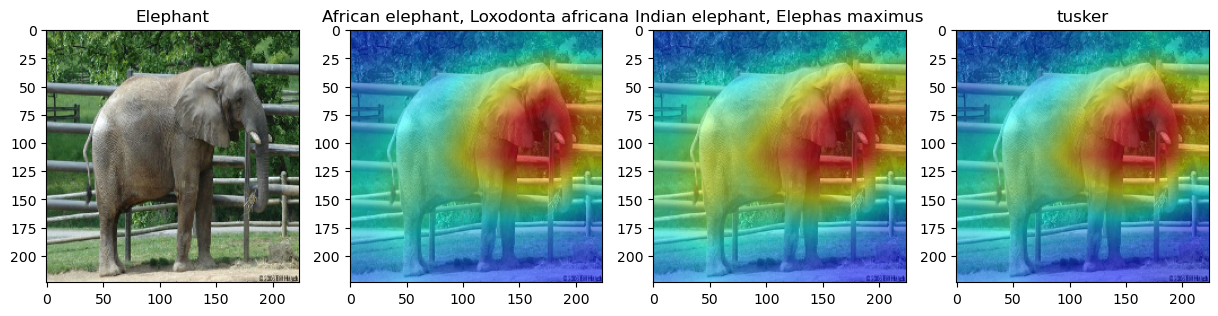

In [8]:
# For the 10 first pictures
# Getting the desired image from the dataset
img = np.array(Image.open(IMAGE_PATH).convert('RGB'))
img = np.float32(cv2.resize(img, (224, 224))) / 255
img_preprocessed = dataset[0][0].view(1, 3, 224, 224)

# passing the image in the model
output = resnet34(img_preprocessed)
values, indices = torch.topk(output, 3)

fig, ax= plt.subplots(1,4, figsize= (15,10))
ax[0].imshow(img)
ax[0].title.set_text("Elephant")
for index, classe in enumerate(indices[0].numpy()):
    heatmap = gradCam(category=classe, model = resnet34, image = img_preprocessed)
    weighted_map = make_heatmap(img,heatmap[-1][-1])
    ax[index+1].imshow(weighted_map)
    ax[index+1].title.set_text(classes[classe])

### Integrated Gradients

* **Overview:** Integrated gradients is an attribution method for understanding the importance of input features (e.g., pixels) for a given model's output. Given an input image, we compute the difference between the model's output for the image and a reference (e.g., all black pixels) for different levels of interpolation between the two. The gradients of this difference with respect to the image pixels are computed at each interpolation level, and then averaged to obtain the final attribution map. This map highlights which pixels in the image were most responsible for the model's output.

In [9]:
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap

from torchvision import datasets, transforms

In [10]:
#Load input and predict with model
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

img = dataset[0][0]
output = resnet34(img.unsqueeze(0))
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

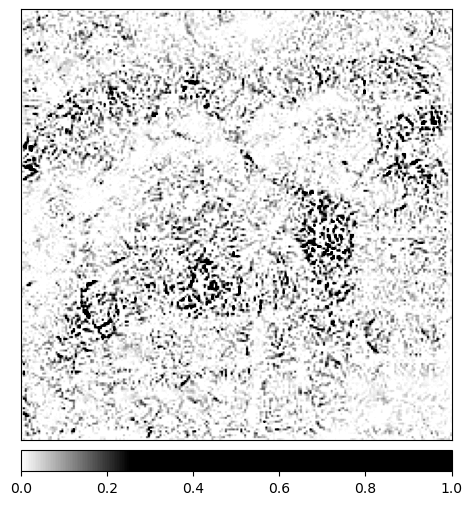

In [13]:
from captum.attr import IntegratedGradients

# Variables and desired prediction
output = resnet34(img.unsqueeze(0))
values, indices = torch.topk(output, 3)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze_()
predicted_label = classes[torch.argmax(output, 1).item()]

# Captum's librairy integrated gradients
integrated_gradients = IntegratedGradients(resnet34)
attributions_ig = integrated_gradients.attribute(
    img.unsqueeze(0), target=pred_label_idx, n_steps=200
)
default_cmap = LinearSegmentedColormap.from_list(
    "custom blue", [(0, "#ffffff"), (0.25, "#000000"), (1, "#000000")], N=256
)


_ = viz.visualize_image_attr(
    np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(img.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    "heat_map",
    cmap=default_cmap,
    show_colorbar=True,
    sign="positive",
    outlier_perc=1,
)

Above we can see the output of the Integrated gradient. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


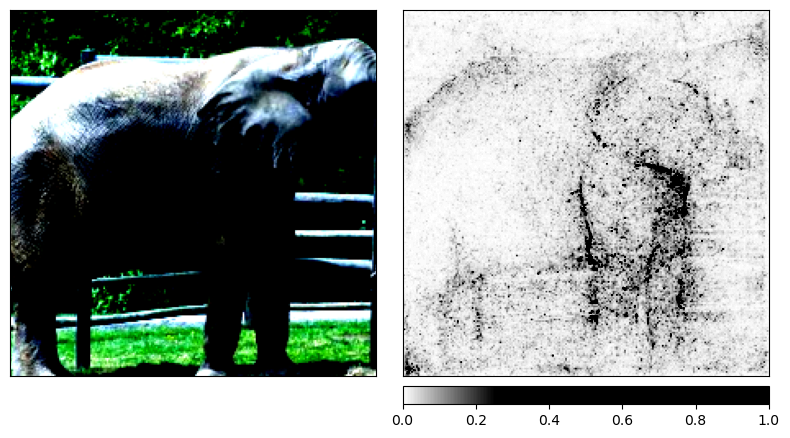

In [ ]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(
    input, nt_samples=10, nt_type="smoothgrad_sq", target=pred_label_idx
)
_ = viz.visualize_image_attr_multiple(
    np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(img.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    ["original_image", "heat_map"],
    ["all", "positive"],
    cmap=default_cmap,
    show_colorbar=True,
)

Aboce we can see the ouput of the Noise Tunnel. This highlights the part the model focuses